# Age recognition 

**Authors**: Richard Šléher, Tomáš Majerník

**Dataset**: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/code?select=train.csv

# TODO
- natrenovat
- pripravit valid/test dataset 
- wandb
- pozret sa ci treba zmenit weighty ked mame pre nejaku classu viac obrazkov aby castejsie classificovalo

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from summarytools import dfSummary
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


Hyperparameters

In [2]:
IMAGE_SIZE = 64

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

## EDA

In [3]:
data = pd.read_csv('data/train.csv')

In [4]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9896.jpg2. 377.jpg3. 7038.jpg4. 10812.jpg5. 11803.jpg6. 22630.jpg7. 9733.jpg8. 6149.jpg9. 10025.jpg10. 14939.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)19,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"10,804 (54.3%)6,706 (33.7%)2,396 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


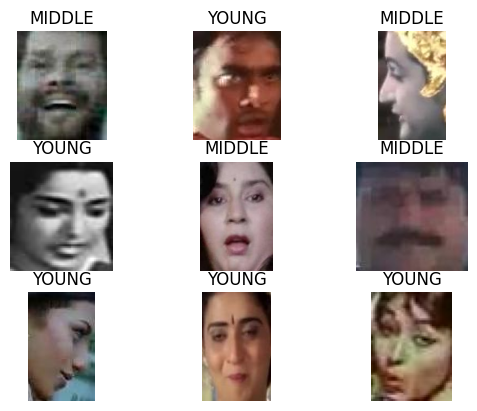

In [5]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread('data/train/' + data.iloc[i]['ID'])
    plt.imshow(img)
    plt.title(data.iloc[i]['Class'])
    plt.axis('off')

plt.show()

In [6]:
sampled_data = data.groupby('Class').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)
remaining_data = data.drop(sampled_data.index)
val_data = remaining_data.reset_index(drop=True)

print(f"Training data size: {sampled_data.shape}")
print(f"Validation data size: {val_data.shape}")

Training data size: (6000, 2)
Validation data size: (13906, 2)


C:\Users\risko\AppData\Local\Temp\ipykernel_9792\1145092374.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('Class').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)


In [7]:
class AgeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2} 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join('data/train/', self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        label = self.label_mapping[label]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = AgeDataset(dataframe=sampled_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=(32), shuffle=True)

val_dataset = AgeDataset(dataframe=val_data, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Model

In [8]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.lin1 = nn.Linear(3136, 64)
        self.lin2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return x

In [9]:
model = CNN(in_channels=3, num_classes=3)

In [10]:
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.to(device)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/30, Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%')

cuda
Epoch [1/30], Loss: 1.0493568226378014, Val Loss: 0.9542113702872704, Val Accuracy: 48.51143391341867%
Epoch [2/30], Loss: 0.9355783820786374, Val Loss: 0.8614646160739592, Val Accuracy: 59.557025744283045%
Epoch [3/30], Loss: 0.8876321978391485, Val Loss: 0.8575664720316043, Val Accuracy: 59.70084855458076%
Epoch [4/30], Loss: 0.8581569125043585, Val Loss: 0.9183251713884288, Val Accuracy: 55.20638573277722%
Epoch [5/30], Loss: 0.8427065201896302, Val Loss: 0.8788759589195252, Val Accuracy: 57.89587228534445%
Epoch [6/30], Loss: 0.813016636574522, Val Loss: 0.7901986320813497, Val Accuracy: 63.375521357687326%
Epoch [7/30], Loss: 0.7849876393980169, Val Loss: 0.7980521615894361, Val Accuracy: 62.836185819070906%
Epoch [8/30], Loss: 0.7711486356689575, Val Loss: 0.7996627170464088, Val Accuracy: 63.778225226520924%
Epoch [9/30], Loss: 0.7455919667127284, Val Loss: 0.8337153829377273, Val Accuracy: 62.06673378397814%
Epoch [10/30], Loss: 0.7212230295259902, Val Loss: 0.774906903847

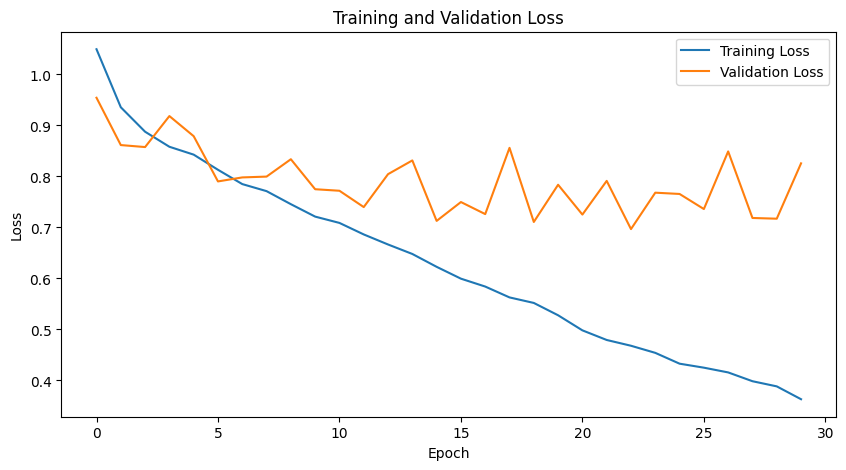

In [12]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

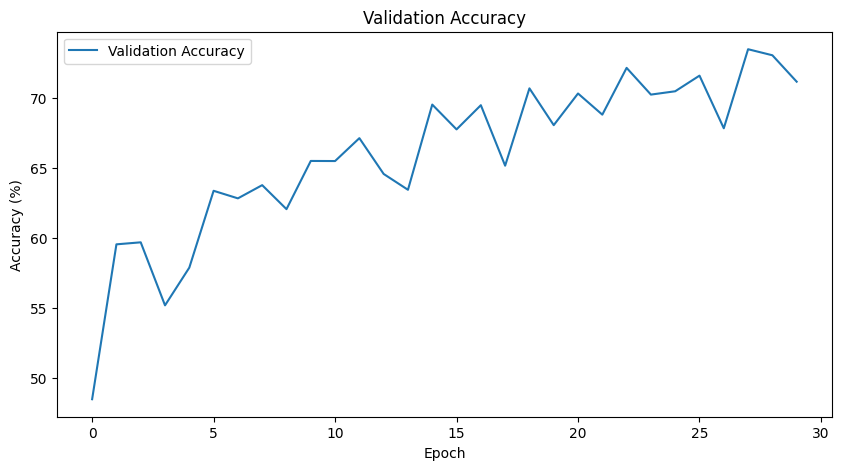

In [13]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [ ]:
#torch.save(model.state_dict(), 'age_recognition_model.pth')